In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# sklearn imports
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_log_error



from xgboost import XGBRegressor

pd.set_option("display.max.columns", None)
pd.set_option("display.max.rows", None)

In [2]:
train = pd.read_csv("data/train.csv")
train, val = train_test_split(train, test_size=0.2)
train_labels = train["SalePrice"]
val_labels = val["SalePrice"]
train.drop(columns = ["SalePrice"], inplace=True)
val.drop(columns = ["SalePrice"], inplace=True)
test = pd.read_csv("data/test.csv")

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1168 entries, 1026 to 1433
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1168 non-null   int64  
 1   MSSubClass     1168 non-null   int64  
 2   MSZoning       1168 non-null   object 
 3   LotFrontage    967 non-null    float64
 4   LotArea        1168 non-null   int64  
 5   Street         1168 non-null   object 
 6   Alley          70 non-null     object 
 7   LotShape       1168 non-null   object 
 8   LandContour    1168 non-null   object 
 9   Utilities      1168 non-null   object 
 10  LotConfig      1168 non-null   object 
 11  LandSlope      1168 non-null   object 
 12  Neighborhood   1168 non-null   object 
 13  Condition1     1168 non-null   object 
 14  Condition2     1168 non-null   object 
 15  BldgType       1168 non-null   object 
 16  HouseStyle     1168 non-null   object 
 17  OverallQual    1168 non-null   int64  
 18  Overa

In [4]:
train.describe(include=object)

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1168,1168,70,1168,1168,1168,1168,1168,1168,1168,1168,1168,1168,1168,1168,1168,1168,1160,1168,1168,1168,1138,1138,1137,1138,1137,1168,1168,1168,1167,1168,1168,612,1110,1110,1110,1110,1168,5,226,43,1168,1168
unique,5,2,2,4,4,2,5,3,25,9,7,5,8,6,8,15,16,4,4,4,6,4,4,4,6,6,6,5,2,5,4,6,5,6,3,5,5,3,3,4,3,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,TA,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Gd,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,919,1164,37,734,1051,1167,843,1107,185,1013,1157,974,589,919,1147,419,409,689,721,1027,525,516,1055,754,340,1005,1142,602,1094,1065,594,1084,299,697,490,1057,1069,1067,3,125,40,1009,956


In [5]:
# cleaning pipeline:

def remove_duplicate_rows(df, keep):
    """
    'drops duplicate rows using built-in pandas function (used for pipe)'
    Args:
        df: dataframe to clean
        keep: {'first', 'last', False} which row to keep
    Returns: transformed (cleaned) dataframe
    """
    df_clean = df.drop_duplicates(keep=keep)
    return df_clean


def remove_low_var_columns(df, df_train, threshold=-1.0):
    """
    'Cleans dataframe columns with low variance'
    Args:
        df: dataframe to clean
        df_train: dataframe to use for identifying columns (train set)
        threshold: [double] variance threshold for numerical columns
    Returns: transformed (cleaned) dataframe
    """
    zero_var_cols = df_train.columns[df_train.nunique() == 1]
    if threshold >= 0:
        df_train_var = df_train.var()
        low_var_columns = df_train_var[df_train_var <= threshold].index
        df_clean = df.drop(columns=low_var_columns, errors="ignore")
    elif threshold < 0:
        df_clean = df
    df_clean = df_clean.drop(columns=zero_var_cols, errors="ignore")
    return df_clean


def drop_na_cols(df, df_train, threshold):
    """
    'Cleans dataframe columns with proportion of more than {threshold} NA values'
    Args:
        df: dataframe to clean
        df_train: dataframe to use for identifying columns (train set)
        threshold: [double, 0-1] proportion of missing values to drop column
    Returns: transformed (cleaned) dataframe
    """
    thresh = len(df_train) * (1 - threshold)
    keep_cols = df_train.dropna(thresh=thresh, axis=1).columns
    df = df[keep_cols]
    return df


def IQR_outlier_removal(df, df_train, columns):
    """
    'cleans training dataset outlier rows by clipping values that are more than 1.5*IQR from median'
    Args:
        df: dataframe to clean
        df_train: dataframe to use for identifying values to clip
        columns: columns to modify
    Returns: transformed (cleaned) dataframe
    """
    df = df.copy()
    df_train = df_train[columns]
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    for col in df_train.select_dtypes(include=numerics).columns:
        if col in df.columns:
            column_median = df_train[col].median()
            percentiles = df_train[col].quantile([0.25, 0.75]).values
            iqr = percentiles[1] - percentiles[0]
            df[col] = np.clip(df[col], column_median - 1.5 * iqr, column_median + 1.5 * iqr)
        else:
            pass
    return df


def obj_to_categorical(df, threshold=1.0):
    """
    'converts object columns to categorical to save memory'
    Args:
        df: dataframe to clean
        threshold: [double] maximum proportion of different values needed to convert column to categorical
    Returns: transformed dataframe with categorical columns
    """
    cols = df.select_dtypes(include='object').columns
    for col in cols:
        ratio = len(df[col].value_counts()) / len(df)
        if ratio < threshold:
            df[col] = df[col].astype('category')
    return df


def interpolate_values(df, interpol_type_dict):
    """
    'interpolates missing values in the training set based on one of the given methods'
    Args:
        df: dataframe with columns to interpolate
        type_dict: [dict] maps interpolation method and respective columns
    Returns: transformed dataframe with imputed values
    """
    for key, value in interpol_type_dict.items():
        for col in value:
            df[col] = df[col].interpolate(method=key)
    return df


def impute_vals(df, df_train, impute_type_dict):
    """
    'imputes missing values in the training set based on one of the given methods'
    Args:
        df: dataframe with columns to impute values into
        type_dict: [dict] maps imputation method and respective columns
    Returns: transformed dataframe with imputed values
    """
    df = df.copy()
    for key, value in impute_type_dict.items():
        if key == "mean":
            for col in value:
                if col in df.columns:
                    df[col] = df[col].fillna(value=df_train[col].mean())
        elif key == "median":
            for col in value:
                if col in df.columns:
                    df[col] = df[col].fillna(value=df_train[col].median())
        elif key == "mode":
            for col in value:
                if col in df.columns:
                    df[col] = df[col].fillna(value=df_train[col].mode()[0])
        elif key in ["bfill", "ffill", "pad"]:
            for col in value:
                if col in df.columns:
                    df[col] = df[col].fillna(method=key)
    return df


def fill_garage_year_built(df, df_train):
    """
    'imputes missing values for the year the garage was built using the year the house was built'
    Args:
        df: dataframe with column to impute values into
        df_train: training dataset
    Returns: transformed dataframe with imputed values
    """
    df = df.copy()
    df["GarageYrBlt"] = df["GarageYrBlt"].fillna(df["YearBuilt"])
    df["GarageYrBlt"] = df["GarageYrBlt"].fillna(df_train["GarageYrBlt"].median())
    return df


def fill_test_set(df, df_train, fill_dict=None):
    """
    'Imputes Rest of missing values in test set'
    Args:
        df: dataframe with column to impute values into
        df_train: training dataset
    Returns: transformed dataframe with imputed values
    """
    df = df.copy()
    if fill_dict:
        pass
        # fassade for coding different strategies
    elif not fill_dict:
        numeric_cols = df.select_dtypes(include=["int16", "int32", "int64", "float16", "float32", "float64"]).columns
        obj_cols = df.select_dtypes(include="object").columns
        for col in numeric_cols:
            df[col].fillna(df_train[col].median(), inplace=True)
        for col in obj_cols:
            df[col].fillna(df_train[col].mode()[0], inplace=True)
    return df


def generate_polynomial_features(df, df_train, k):
    """
    'creates polynomial feature transformations'
    Args:
        df: dataframe to transform
        df_train: training dataset
        k: degree of polynomials to generate
    Returns: transformed dataframe with polynomial features
    """
    df = df.copy()
    categorical_columns = list(df_train.select_dtypes(include=["category"]).columns)
    numeric_columns = list(
        df_train.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64']).columns)
    train_numeric = df_train[numeric_columns]
    df_numeric = df[numeric_columns]
    poly = PolynomialFeatures(k)
    poly.fit(train_numeric)
    df_poly = pd.DataFrame(data=poly.transform(df_numeric), columns=poly.get_feature_names(numeric_columns))
    df = pd.concat([df_poly.reset_index(drop=True), df[categorical_columns].reset_index(drop=True)], axis=1)
    return df


def get_num_cat_columns(df):
    categorical_columns = list(df.select_dtypes(include=["category"]).columns)
    numerical_columns = list(
        df.select_dtypes(include=["int16", "int32", "int64", "float16", "float32", "float64"]).columns)
    return numerical_columns, categorical_columns


def log_transform_labels(series, forward=True):
    if forward:
        return np.log(series)
    elif not forward:
        return np.exp(series)
    

In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

In [7]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
iqr_columns = train.select_dtypes(include=numerics).columns

impute_dict = {
    "median": ["LotFrontage", "MasVnrArea"],
    "mode": ["MasVnrType", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "Electrical",
             "GarageType", "GarageFinish", "GarageQual", "GarageCond"]
}

train_clean = (
    train
        .pipe(drop_na_cols, train, 0.3)
        .pipe(remove_low_var_columns, train)
        .pipe(IQR_outlier_removal, train, iqr_columns)
        .pipe(impute_vals, train, impute_dict)
        .pipe(fill_garage_year_built, train)
)

print("cleaned train")
val_clean = (
    val
        .pipe(drop_na_cols, train, 0.3)
        .pipe(remove_low_var_columns, train)
        .pipe(IQR_outlier_removal, train, iqr_columns)
        .pipe(impute_vals, train, impute_dict)
        .pipe(fill_garage_year_built, train)
        .pipe(fill_test_set, train)
)
print("cleaned val")
test_clean = (
    test
        .pipe(drop_na_cols, train, 0.3)
        .pipe(remove_low_var_columns, train)
        .pipe(IQR_outlier_removal, train, iqr_columns)
        .pipe(impute_vals, train, impute_dict)
        .pipe(fill_garage_year_built, train)
        .pipe(fill_test_set, train)
)
print("cleaned test")


cleaned train
cleaned val
cleaned test


In [8]:
train_cat = train_clean.pipe(obj_to_categorical)
train_prepared = train_cat.pipe(generate_polynomial_features, train_cat, 2)
val_cat = val_clean.pipe(obj_to_categorical)
val_prepared = val_cat.pipe(generate_polynomial_features, train_cat, 2)
test_cat = test_clean.pipe(obj_to_categorical)
test_prepared = test_cat.pipe(generate_polynomial_features, train_cat, 2)

In [9]:
train_prepared.head()

,1,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,Id^2,Id MSSubClass,Id LotFrontage,Id LotArea,Id OverallQual,Id OverallCond,Id YearBuilt,Id YearRemodAdd,Id MasVnrArea,Id BsmtFinSF1,Id BsmtFinSF2,Id BsmtUnfSF,Id TotalBsmtSF,Id 1stFlrSF,Id 2ndFlrSF,Id LowQualFinSF,Id GrLivArea,Id BsmtFullBath,Id BsmtHalfBath,Id FullBath,Id HalfBath,Id BedroomAbvGr,Id KitchenAbvGr,Id TotRmsAbvGrd,Id Fireplaces,Id GarageYrBlt,Id GarageCars,Id GarageArea,Id WoodDeckSF,Id OpenPorchSF,Id EnclosedPorch,Id 3SsnPorch,Id ScreenPorch,Id PoolArea,Id MiscVal,Id MoSold,Id YrSold,MSSubClass^2,MSSubClass LotFrontage,MSSubClass LotArea,MSSubClass OverallQual,MSSubClass OverallCond,MSSubClass YearBuilt,MSSubClass YearRemodAdd,MSSubClass MasVnrArea,MSSubClass BsmtFinSF1,MSSubClass BsmtFinSF2,MSSubClass BsmtUnfSF,MSSubClass TotalBsmtSF,MSSubClass 1stFlrSF,MSSubClass 2ndFlrSF,MSSubClass LowQualFinSF,MSSubClass GrLivArea,MSSubClass BsmtFullBath,MSSubClass BsmtHalfBath,MSSubClass FullBath,MSSubClass HalfBath,MSSubClass BedroomAbvGr,MSSubClass KitchenAbvGr,MSSubClass TotRmsAbvGrd,MSSubClass Fireplaces,MSSubClass GarageYrBlt,MSSubClass GarageCars,MSSubClass GarageArea,MSSubClass WoodDeckSF,MSSubClass OpenPorchSF,MSSubClass EnclosedPorch,MSSubClass 3SsnPorch,MSSubClass ScreenPorch,MSSubClass PoolArea,MSSubClass MiscVal,MSSubClass MoSold,MSSubClass YrSold,LotFrontage^2,LotFrontage LotArea,LotFrontage OverallQual,LotFrontage OverallCond,LotFrontage YearBuilt,LotFrontage YearRemodAdd,LotFrontage MasVnrArea,LotFrontage BsmtFinSF1,LotFrontage BsmtFinSF2,LotFrontage BsmtUnfSF,LotFrontage TotalBsmtSF,LotFrontage 1stFlrSF,LotFrontage 2ndFlrSF,LotFrontage LowQualFinSF,LotFrontage GrLivArea,LotFrontage BsmtFullBath,LotFrontage BsmtHalfBath,LotFrontage FullBath,LotFrontage HalfBath,LotFrontage BedroomAbvGr,LotFrontage KitchenAbvGr,LotFrontage TotRmsAbvGrd,LotFrontage Fireplaces,LotFrontage GarageYrBlt,LotFrontage GarageCars,LotFrontage GarageArea,LotFrontage WoodDeckSF,LotFrontage OpenPorchSF,LotFrontage EnclosedPorch,LotFrontage 3SsnPorch,LotFrontage ScreenPorch,LotFrontage PoolArea,LotFrontage MiscVal,LotFrontage MoSold,LotFrontage YrSold,LotArea^2,LotArea OverallQual,LotArea OverallCond,LotArea YearBuilt,LotArea YearRemodAdd,LotArea MasVnrArea,LotArea BsmtFinSF1,LotArea BsmtFinSF2,LotArea BsmtUnfSF,LotArea TotalBsmtSF,LotArea 1stFlrSF,LotArea 2ndFlrSF,LotArea LowQualFinSF,LotArea GrLivArea,LotArea BsmtFullBath,LotArea BsmtHalfBath,LotArea FullBath,LotArea HalfBath,LotArea BedroomAbvGr,LotArea KitchenAbvGr,LotArea TotRmsAbvGrd,LotArea Fireplaces,LotArea GarageYrBlt,LotArea GarageCars,LotArea GarageArea,LotArea WoodDeckSF,LotArea OpenPorchSF,LotArea EnclosedPorch,LotArea 3SsnPorch,LotArea ScreenPorch,LotArea PoolArea,LotArea MiscVal,LotArea MoSold,LotArea YrSold,OverallQual^2,OverallQual OverallCond,OverallQual YearBuilt,OverallQual YearRemodAdd,OverallQual MasVnrArea,OverallQual BsmtFinSF1,OverallQual BsmtFinSF2,OverallQual BsmtUnfSF,OverallQual TotalBsmtSF,OverallQual 1stFlrSF,OverallQual 2ndFlrSF,OverallQual LowQualFinSF,OverallQual GrLivArea,OverallQual BsmtFullBath,OverallQual BsmtHalfBath,OverallQual FullBath,OverallQual HalfBath,OverallQual BedroomAbvGr,OverallQual KitchenAbvGr,OverallQual TotRmsAbvGrd,OverallQual Fireplaces,OverallQual GarageYrBlt,OverallQual GarageCars,OverallQual GarageArea,OverallQual WoodDeckSF,OverallQual OpenPorchSF,OverallQual EnclosedPorch,OverallQual 3SsnPorch,OverallQual ScreenPorch,OverallQual PoolArea,OverallQual MiscVal,OverallQual MoSold,OverallQual YrSold,OverallCond^2,OverallCond YearBuilt,OverallCond YearRemodAdd,OverallCond MasVnrArea,OverallCond BsmtFinSF1,OverallCond BsmtFinSF2,OverallCond Bsm

In [10]:
train_prepared.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1168 entries, 0 to 1167
Columns: 779 entries, 1 to SaleCondition
dtypes: category(38), float64(741)
memory usage: 6.7 MB


In [11]:
categorical_columns = list(train_prepared.select_dtypes(include=["category"]).columns)
numerical_columns = list(
    train_prepared.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64']).columns)

categorical_encoder = OneHotEncoder(handle_unknown='ignore')

numerical_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy='mean')),
    ("Scaler", StandardScaler())
])

preprocessing = ColumnTransformer(
    [("cat", categorical_encoder, categorical_columns),
     ("num", numerical_pipe, numerical_columns)])
rf = Pipeline([
    ("preprocess", preprocessing),
    ("model", RandomForestRegressor(random_state=42, n_estimators=100, min_samples_leaf=3))])

In [12]:
rf.fit(train_prepared, train_labels)
print("RF train R2: %0.3f" % rf.score(train_prepared, train_labels))
print("RF train RMSE: %0.3f" % np.sqrt(mean_squared_log_error(train_labels, rf.predict(train_prepared))))#, squared=False))
print("RF val R2: %0.3f" % rf.score(val_prepared, val_labels))
print("RF val RMSE: %0.3f" % np.sqrt(mean_squared_log_error(val_labels, rf.predict(val_prepared))))#, squared=False))

RF train R2: 0.967
RF train RMSE: 0.071
RF val R2: 0.850
RF val RMSE: 0.150


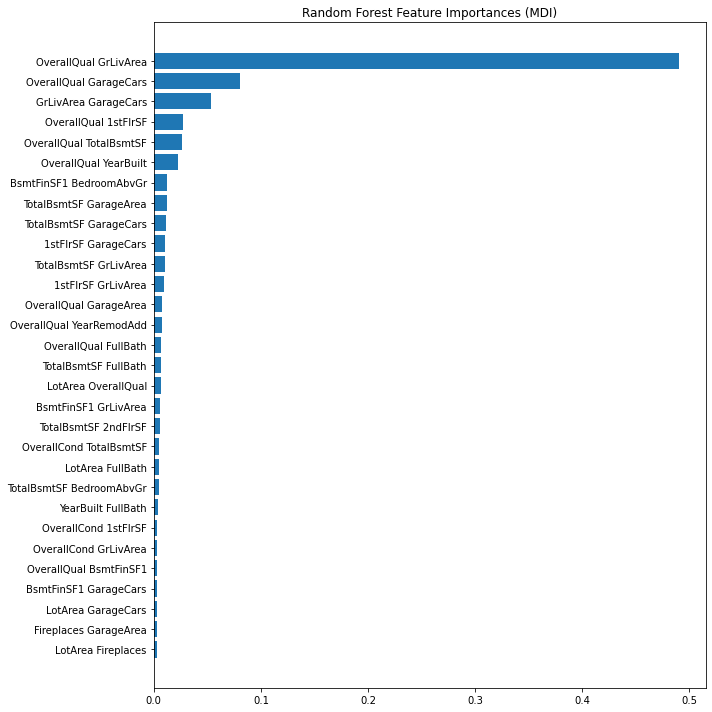

In [13]:
#numerical_columns = (rf.named_steps['preprocess']
#    .named_transformers_['num'].named_steps['polynomials']).get_feature_names(numeric_columns)
ohe = (rf.named_steps['preprocess']
    .named_transformers_['cat'])
feature_names = ohe.get_feature_names(categorical_columns)
feature_names = np.r_[feature_names, numerical_columns]

tree_feature_importances = (
    rf.named_steps['model'].feature_importances_)
sorted_idx = tree_feature_importances.argsort()
sorted_importances = tree_feature_importances[sorted_idx][-30:]
sorted_names = feature_names[sorted_idx][-30:]

y_ticks = np.arange(0, len(sorted_names))
fig, ax = plt.subplots(figsize=(10, 10))
ax.barh(y_ticks, sorted_importances)
ax.set_yticks(y_ticks)
ax.set_yticklabels(sorted_names)
ax.set_title("Random Forest Feature Importances (MDI)")
fig.tight_layout()
plt.show()

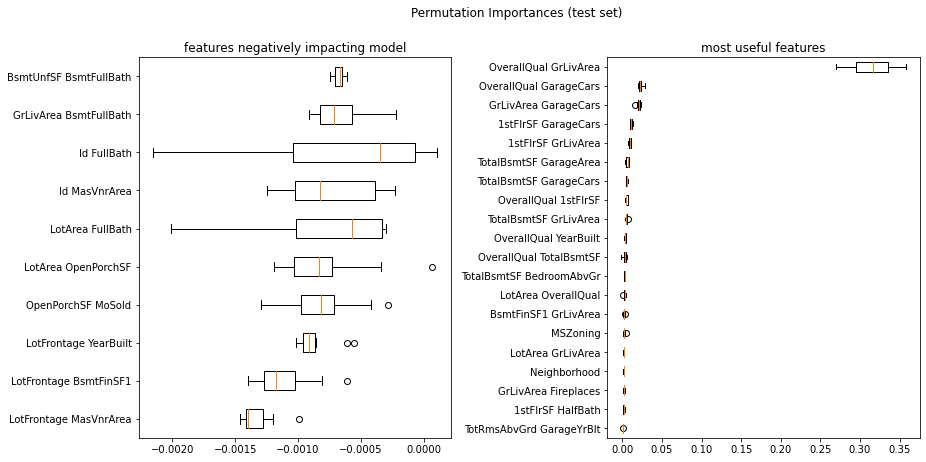

In [14]:
result = permutation_importance(rf, val_prepared, val_labels, n_repeats=10,
                                random_state=42, n_jobs=12)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(1,2, figsize=(14,7))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)
ax[0].boxplot(result.importances[sorted_idx][:10].T,
           vert=False, labels=val_prepared.columns[sorted_idx][:10])
ax[0].set_title("features negatively impacting model")
ax[1].boxplot(result.importances[sorted_idx][-20:].T,
           vert=False, labels=val_prepared.columns[sorted_idx][-20:])
ax[1].set_title("most useful features")
fig.suptitle("Permutation Importances (test set)")
plt.show()

In [15]:
final_features = val_prepared.columns[sorted_idx][-500:]

In [16]:
# implement xgboost regressor

In [17]:
X_train = pd.concat([train_prepared, val_prepared], axis=0).reset_index(drop=True).loc[:,final_features]
numerical_columns, categorical_columns = get_num_cat_columns(X_train)

preprocessing = ColumnTransformer(
    [("cat", categorical_encoder, categorical_columns),
     ("num", numerical_pipe, numerical_columns)])

X = preprocessing.fit_transform(X_train)
y = pd.concat([log_transform_labels(train_labels), log_transform_labels(val_labels)]).reset_index(drop=True)

model = XGBRegressor(n_estimators=500, max_depth=13, eta=0.1, subsample=0.8, colsample_bytree=0.8)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = abs(cross_val_score(model, X, y, scoring = "neg_mean_squared_log_error", cv=cv, n_jobs=12))
print('Mean RMSE: %.3f' % (np.sqrt(scores.mean())))

Mean RMSE: 0.010


In [18]:
param_grid = {
    "eta": [0.1, 0.15, 0.2],
    "max_depth": [2,3,4],
    "subsample": [0.6, 0.7, 0.75],
    "lambda": [ 0.5, 1, 1.5],
}

gscv = GridSearchCV(model, param_grid, scoring="neg_mean_squared_log_error", n_jobs=14)
gscv.fit(X,y)

GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.8,
                                    eta=0.1, gamma=None, gpu_id=None,
                                    importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=13, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=500, n_jobs=None,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=0.8,
                                    tree_method=None, validate_parameters=None,
 

In [19]:
print("Best Parmeters found: " + str(gscv.best_params_))
print("Best Score reached: " + str(np.sqrt(abs(gscv.best_score_))))

Best Parmeters found: {'eta': 0.1, 'lambda': 1, 'max_depth': 3, 'subsample': 0.7}
Best Score reached: 0.01044280007654366


In [20]:
X_test = test_prepared.loc[:, final_features]
X_test = preprocessing.transform(X_test)
y_test = gscv.predict(X_test)

In [22]:
log_transform_labels(y_test, forward=False)

array([123173.09, 145456.38, 171241.97, ..., 150743.95, 106725.08,
       230810.83], dtype=float32)

In [25]:
results = pd.DataFrame()
results["Id"] = test["Id"]
results["SalePrice"] = log_transform_labels(y_test, forward=False)

In [26]:
results.to_csv("housing_regression_results.csv", index=False)